In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
import fastf1 
from fastf1 import get_session
import matplotlib.pyplot as plt
import seaborn as sns

from f1_etl import SessionConfig, DataConfig, create_safety_car_dataset

fastf1.Cache.enable_cache('E:\School Stuff\F1cache')

In [5]:
# Define a single race session
session = SessionConfig(
    year=2022,
    race="Sao Paolo Grand Prix",
    session_type="R"  # Race
)

# Configure the dataset
config = DataConfig(
    sessions=[session],
    cache_dir="E:\School Stuff\F1cache"
)

# Generate the dataset
dataset_22 = create_safety_car_dataset(
    config=config,
    window_size=100,
    prediction_horizon=10
)

print(f"Generated {dataset_22['config']['n_sequences']} sequences")
print(f"Features: {dataset_22['config']['feature_names']}")
print(f"Class distribution: {dataset_22['class_distribution']}")

Loading session: 2022 Sao Paolo Grand Prix R
Loading from cache: E:\School Stuff\F1cache\2022_Sao_Paolo_Grand_Prix_R.pkl


2025-06-28 16:55:31,553 - f1_etl - INFO - Processing 1512260 total telemetry rows
2025-06-28 16:55:31,554 - f1_etl - INFO - Grouping by: ['SessionId', 'Driver']
2025-06-28 16:55:52,377 - f1_etl - INFO - Total sequences generated: 30220
2025-06-28 16:55:52,493 - f1_etl - INFO - Generated 30220 sequences with shape (30220, 100, 9)
2025-06-28 16:55:52,518 - f1_etl - INFO - Handling missing values with strategy: forward_fill


Generated 30220 sequences
Features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
Class distribution: {'green': 25860, 'safety_car': 3620, 'vsc': 460, 'yellow': 280}


In [49]:
y_2022 = (dataset_22['y'] == 1).astype(np.float32)
print("\nBinary label distribution:")
print(f"  Class 0 (negative): {np.sum(y_2022 == 0)} samples")
print(f"  Class 1 (positive): {np.sum(y_2022 == 1)} samples")


Binary label distribution:
  Class 0 (negative): 26600 samples
  Class 1 (positive): 3620 samples


In [6]:
# Define a single race session
session = SessionConfig(
    year=2023,
    race="Sao Paolo Grand Prix",
    session_type="R"  # Race
)

# Configure the dataset
config = DataConfig(
    sessions=[session],
    cache_dir="E:\School Stuff\F1cache"
)

# Generate the dataset
dataset_23 = create_safety_car_dataset(
    config=config,
    window_size=100,
    prediction_horizon=10
)

print(f"Generated {dataset_23['config']['n_sequences']} sequences")
print(f"Features: {dataset_23['config']['feature_names']}")
print(f"Class distribution: {dataset_23['class_distribution']}")

Loading session: 2023 Sao Paolo Grand Prix R


events      WARNING 	Correcting user input 'Sao Paolo Grand Prix' to 'São Paulo Grand Prix'
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63'

Generated 33320 sequences
Features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
Class distribution: {'green': 28720, 'red': 3860, 'safety_car': 500, 'yellow': 240}


In [51]:
y_2023 = (dataset_23['y'] == 2).astype(np.float32)
print("\nBinary label distribution:")
print(f"  Class 0 (negative): {np.sum(y_2023 == 0)} samples")
print(f"  Class 1 (positive): {np.sum(y_2023 == 1)} samples")


Binary label distribution:
  Class 0 (negative): 32820 samples
  Class 1 (positive): 500 samples


In [57]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        #self.sigmoid = nn.Sigmoid()  # For binary classification ##NEED TO REMOVE

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take last time step
        out = self.fc(out)
        return out

In [58]:
# Create data loaders
train_dataset = TensorDataset(
    torch.tensor(dataset_22['X'], dtype=torch.float32),
    torch.tensor(y_2022, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Calculate class weights
pos_count = np.sum(dataset_22['y'])
neg_count = len(dataset_22['y']) - pos_count
pos_weight = torch.tensor([neg_count / pos_count])

print(f"\nTRAINING DATA STATISTICS:")
print(f"Total training sequences: {len(dataset_22['y']):,}")
print(f"Negative samples: {neg_count:,}")
print(f"Positive samples: {pos_count:,}")
print(f"Class imbalance ratio: {neg_count/pos_count:.1f}:1")
print(f"Positive class weight: {pos_weight.item():.1f}")

# GPU Setup - ADD THIS SECTION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Move pos_weight to GPU BEFORE creating criterion
pos_weight = pos_weight.to(device)

# Model setup
model = GRUClassifier(input_dim=len(dataset_22['X'][0, 0, :]), hidden_dim=64, num_layers=2, output_dim=1)
model = model.to(device)  # Move model to GPU

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Now pos_weight is on GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"\nMODEL ARCHITECTURE:")
print(f"Input dimension: {len(dataset_22['X'][0, 0, :])}")
print(f"Hidden dimension: 64")
print(f"Number of layers: 2")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


TRAINING DATA STATISTICS:
Total training sequences: 30,220
Negative samples: 24,840
Positive samples: 5,380
Class imbalance ratio: 4.6:1
Positive class weight: 4.6

Using device: cuda

MODEL ARCHITECTURE:
Input dimension: 9
Hidden dimension: 64
Number of layers: 2
Total parameters: 39,425


In [59]:
# Move model and criterion to GPU
model = model.to(device)
criterion = criterion.to(device)

# Training
print(f"\n{'='*60}")
print("STARTING TRAINING")
print(f"{'='*60}")
num_epochs = 50
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}: Loss = {avg_loss:.4f}")
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_multi_driver_model.pth')
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'feature_cols': dataset_22['config']['feature_names'],
            'pos_weight': pos_weight.item(),
            #'train_drivers': list(set(train_drivers)),
            #'test_drivers': list(set(test_drivers))
        }, f'multi_driver_checkpoint_epoch_{epoch+1}.pth')
print(f"\nTraining completed! Best loss: {best_loss:.4f}")


STARTING TRAINING
Epoch  1/50: Loss = 0.6973
Epoch  2/50: Loss = 0.4718
Epoch  3/50: Loss = 0.4079
Epoch  4/50: Loss = 0.3322
Epoch  5/50: Loss = 0.3112
Epoch  6/50: Loss = 0.3046
Epoch  7/50: Loss = 0.3052
Epoch  8/50: Loss = 0.2805
Epoch  9/50: Loss = 0.2727
Epoch 10/50: Loss = 0.2612
Epoch 11/50: Loss = 0.2597
Epoch 12/50: Loss = 0.2522
Epoch 13/50: Loss = 0.2442
Epoch 14/50: Loss = 0.2402
Epoch 15/50: Loss = 0.2343
Epoch 16/50: Loss = 0.2817
Epoch 17/50: Loss = 0.2474
Epoch 18/50: Loss = 0.2330
Epoch 19/50: Loss = 0.2306
Epoch 20/50: Loss = 0.2191
Epoch 21/50: Loss = 0.2275
Epoch 22/50: Loss = 0.2508
Epoch 23/50: Loss = 0.2179
Epoch 24/50: Loss = 0.2148
Epoch 25/50: Loss = 0.2115
Epoch 26/50: Loss = 0.2169
Epoch 27/50: Loss = 0.2087
Epoch 28/50: Loss = 0.1984
Epoch 29/50: Loss = 0.1952
Epoch 30/50: Loss = 0.1961
Epoch 31/50: Loss = 0.1827
Epoch 32/50: Loss = 0.1916
Epoch 33/50: Loss = 0.1921
Epoch 34/50: Loss = 0.1846
Epoch 35/50: Loss = 0.1842
Epoch 36/50: Loss = 0.1771
Epoch 37/

In [66]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_multi_driver_model.pth'))

# Get predictions
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(dataset_23['X'], dtype=torch.float32).to(device))
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()

# Find best threshold
from sklearn.metrics import precision_recall_curve, f1_score

precision_vals, recall_vals, thresholds = precision_recall_curve(y_2023, probs)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"\nBest threshold: {best_threshold:.3f}")
print(f"Best F1 score: {f1_scores[best_threshold_idx]:.3f}")

# Overall performance
pred_binary = (probs > best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(f"\n{'='*60}")
print("OVERALL PERFORMANCE (ALL DRIVERS)")
print(f"{'='*60}")
print(classification_report(y_2023, pred_binary, target_names=['No Safety Car', 'Safety Car']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_2023, pred_binary)
print(f"                 Predicted")
print(f"                 No SC  Safety Car")
print(f"Actual No SC     {cm[0,0]:5d}  {cm[0,1]:9d}")
print(f"Actual Safety Car {cm[1,0]:4d}  {cm[1,1]:9d}")

C:\Users\jcf03\AppData\Local\Temp\ipykernel_20360\2431560349.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_multi_driver_model.pt


Best threshold: 0.995
Best F1 score: 0.228

OVERALL PERFORMANCE (ALL DRIVERS)
               precision    recall  f1-score   support

No Safety Car       0.99      0.96      0.98     32820
   Safety Car       0.15      0.46      0.23       500

     accuracy                           0.95     33320
    macro avg       0.57      0.71      0.60     33320
 weighted avg       0.98      0.95      0.96     33320


Confusion Matrix:
                 Predicted
                 No SC  Safety Car
Actual No SC     31509       1311
Actual Safety Car  268        232


Very high confidence predictions (>0.99): 2120
Of these, actual safety cars: 241.0


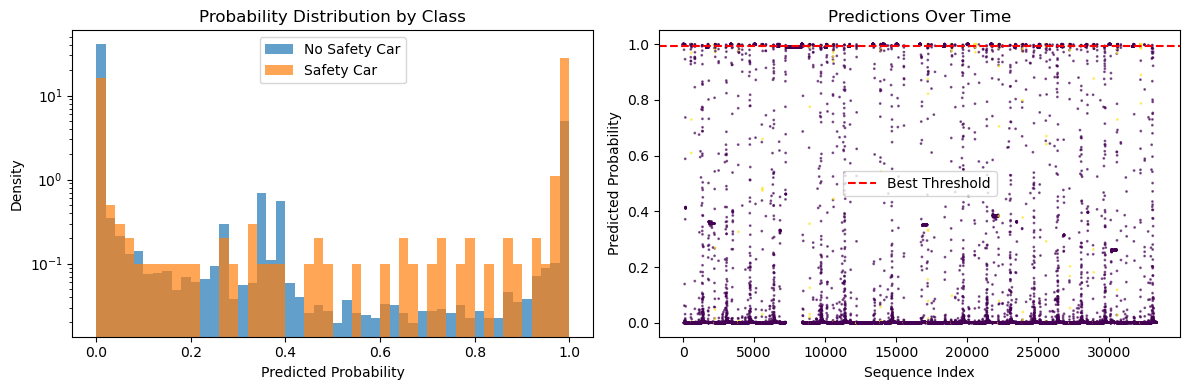

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(probs[y_2023 == 0], bins=50, alpha=0.7, label='No Safety Car', density=True)
plt.hist(probs[y_2023 == 1], bins=50, alpha=0.7, label='Safety Car', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.title('Probability Distribution by Class')
plt.yscale('log')

plt.subplot(1, 2, 2)
# Look at very high confidence predictions
high_conf_mask = probs > 0.99
print(f"Very high confidence predictions (>0.99): {high_conf_mask.sum()}")
print(f"Of these, actual safety cars: {y_2023[high_conf_mask].sum()}")

plt.scatter(range(len(probs)), probs, c=y_2023, alpha=0.6, s=1)
plt.xlabel('Sequence Index')
plt.ylabel('Predicted Probability')
plt.title('Predictions Over Time')
plt.axhline(y=0.995, color='red', linestyle='--', label='Best Threshold')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# Try different thresholds to see precision-recall trade-off
for thresh in [0.99, 0.995, 0.998, 0.999]:
    pred = (probs > thresh).astype(int)
    precision = precision_score(y_2023, pred, zero_division=0)
    recall = recall_score(y_2023, pred, zero_division=0)
    f1 = f1_score(y_2023, pred, zero_division=0)
    
    tp = np.sum((pred == 1) & (y_2023 == 1))
    fp = np.sum((pred == 1) & (y_2023 == 0))
    
    print(f"Threshold {thresh}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, TP={tp}, FP={fp}")

Threshold 0.99: P=0.114, R=0.482, F1=0.184, TP=241, FP=1879
Threshold 0.995: P=0.149, R=0.456, F1=0.225, TP=228, FP=1299
Threshold 0.998: P=0.142, R=0.398, F1=0.209, TP=199, FP=1205
Threshold 0.999: P=0.116, R=0.302, F1=0.168, TP=151, FP=1146
